<a href="https://colab.research.google.com/github/Rogerio-mack/Arte_Generativa/blob/main/Magenta_art_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="Universidade Presbiteriana Mackenzie">
</head>

<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg" width=300, align="right"> 
<!-- <h1 align=left><font size = 6, style="color:rgb(200,0,0)"> optional title </font></h1> -->

# **Aplicação de Estilos em Imagens com IA e `Python`**  

Neste notebook você empregar **Inteligência Artificial**, através de um modelo de **Deep Learning** em `TensorFlow` pré-treinado para aplicar *estilos* a uma imagem original. 


*   Aprenda um pouco sobre o que é a aplicação ou transferência de estilo com uma rede neural
*   Veja um exemplo de como aplicar estilo a uma imagem
*   Crie sua arte carregando uma foto e uma imagem de estilo de sua preferência

<br> 

> **(\*) Para exposição tire uma foto do Mackenzie, pode ser um edifício, uma área do campus, uma sala com seus colegas, e aplique o estilo de sua preferência.**



<br>

<small> 
rogerio.oliveira@mackenzie.br

---


# Transferência de Estilo

<img src="http://meusite.mackenzie.br/rogerio/painters/all_figs.jpg" width=1000> 


De modo simples, a ideia modelo generativo para aplicação de estilos é a de aplicar a mesma  distribuição de probabilidade, as mesmas estatísticas, dos dados da imagem estilo à imagem original. Essas estatísticas são extraídas das imagens usando uma **rede neural Convolutional**.

Acesse e experimente online clicando [aqui](https://style-transfer.glitch.me/) 

![imagem](https://www.fritz.ai/images/fast_style_transfer_arch.jpg)

# Para Saber Mais

Se você quiser saber mais sobre essa técnica  você pode começar por aqui:

* Fritz Lab, [**Style Transfer Guide**](https://www.fritz.ai/style-transfer/)
* TensorFlow, [**Neural style transfer**](https://www.tensorflow.org/tutorials/generative/style_transfer)

# Magenta

`Magenta` é um projeto de código aberto da **Google IA** que emprega o aprendizado de máquina, mais particularmente Deep Learning, para gerar arte. Atualmente o projeto suporta aplicação de estilo em imagens e a produção de *scketchs* (desenhos semelhantes a esboços manuais feitos por um ser humano), mas também a produção de *música generativa*! Você pode acessar mais sobre o projeto `Magenta` [aqui](https://magenta.tensorflow.org/). 



In [1]:
#@markdown
from IPython.display import IFrame
IFrame("https://magenta.tensorflow.org/", 800,500)

# Imports

Além dos imports básicos como o `NumPy` e `Matplotlib`, importamos o `TensorFlow` e o `TensorFlow Hub`

[TensorFlow](https://www.tensorflow.org/)  é uma plataforma de código aberto de ponta a ponta para aprendizado de máquina, particularmente para implementação de modelos de redes neurais profundas. Juntamente com [PyTorch](https://pytorch.org) é um dos principais *frameworks* empregados no desenvolvimento de redes *deep learning*. O `Magenta` é um modelo de deep learning que emprega uma rede convolucional (as mais empregadas no processamento de imagens) desenvolvida e executada nessa plataforma. 

O [TensorFlow Hub](https://www.tensorflow.org/hub) é um repositório de modelos de aprendizado de máquina pré treinados, prontos para ajustes finos e implantáveis ​​em qualquer lugar. O `Magenta` é um dos modelos pré treinados que encontramos para uso público no TensorFlow Hub. 

Este exemplo foi contruído e validado nas versões:
```
TF Version:  2.8.2
TF Hub version:  0.12.0
``` 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)
print("GPU available: ", tf.config.list_physical_devices('GPU')) # havendo disponibilidade o modelo executa empregando GPU


TF Version:  2.8.2
TF Hub version:  0.12.0
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## OpenCV

[OpenCV](https://opencv.org/), desenvolvida originalmente pela Intel, é uma das mais empregadas bibliotecas de IA para o desenvolvimento de aplicativos na área de Visão computacional. Aqui empregamos o OpenCV apenas para fazer o resize da imagem estilo para a altura da imagem original mantendo as suas proporções. O tamanho da imagem original será mantido e empregado na imagem estilizada. A menos que tenha interesse, você não precisa se preocupar com este código.


In [4]:
#@markdown resize image
# source: https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
import cv2
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):

    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

# Aplicando o Modelo `Magenta` para Estilos

A função abaixo retorna uma imagem estilizada  da imagem *conteúdo* (`content_image`) aplicando uma imagem estilo (`style_image`) desejada. Basicamente são os seguintes passos:

1. Converte a matriz de pixels das imagens para *tensores* que `arrays` operados pelo `TensorFlow`
2. Carrega o modelo pré treinado `Magenta` de aplicação de estilos
3. Aplica a rede pré treinada as imagens fornecidas
4. Converte o `array` resultante em uma matriz de pixels

In [5]:
def generate_stylized(content_image,style_image):

  # convert image array to normalized tensor arrays
  content_image = content_image.astype(np.float32)[np.newaxis, ...] / 255.
  style_image = style_image.astype(np.float32)[np.newaxis, ...] / 255.

  # Load image stylization model from TF hub
  hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

  # Apply pre trained model
  outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
  stylized_image = outputs[0]

  stylized_image = np.array(stylized_image)

  # reshape array to the stylized image 
  stylized_image = stylized_image.reshape(stylized_image.shape[1],stylized_image.shape[2],stylized_image.shape[3])

  return stylized_image

# Exemplo: **O Mackenzie *pintado* por Kandinsky e Tarsila** 

## Load das imagens

Vamos trazer uma imagem do Mackenzie e aplicar o estilo de duas pinturas famosas de *Kandinsky* e a brasileira *Tarsila*. Mais adiante haverá um código para você fazer o upload das imagens a partir de  arquivos locais da sua máquina. 

In [22]:
!wget http://meusite.mackenzie.br/rogerio/painters/mackenzie_3740_041017.jpg
!wget http://meusite.mackenzie.br/rogerio/painters/Kandinsky.jpg
!wget http://meusite.mackenzie.br/rogerio/painters/Tarsila.jpg

!ls /content


--2022-09-27 16:31:18--  http://meusite.mackenzie.br/rogerio/painters/mackenzie_3740_041017.jpg
Resolving meusite.mackenzie.br (meusite.mackenzie.br)... 168.197.92.228
Connecting to meusite.mackenzie.br (meusite.mackenzie.br)|168.197.92.228|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 199513 (195K) [image/jpeg]
Saving to: ‘mackenzie_3740_041017.jpg.5’

mackenzie_3740_0410 100%[===================>] 194.84K   289KB/s    in 0.7s    

2022-09-27 16:31:19 (289 KB/s) - ‘mackenzie_3740_041017.jpg.5’ saved [199513/199513]

--2022-09-27 16:31:19--  http://meusite.mackenzie.br/rogerio/painters/Kandinsky.jpg
Resolving meusite.mackenzie.br (meusite.mackenzie.br)... 168.197.92.228
Connecting to meusite.mackenzie.br (meusite.mackenzie.br)|168.197.92.228|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195196 (191K) [image/jpeg]
Saving to: ‘Kandinsky.jpg.1’

Kandinsky.jpg.1     100%[===================>] 190.62K   284KB/s    in 0.7s    

2022-09-27

## Aplicação do Estilo

Fazemos o resize da imagem de estilo para ajustar a nossa imagem original de conteúdo. Aplicamos a nossa função para gerar a imagem estilizada e, em seguida, podemos exibir as imagens empregadas e a estilizada. 

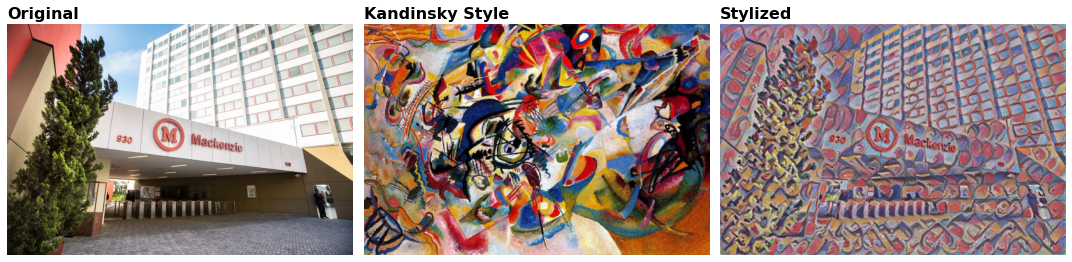

In [28]:
content_image = plt.imread('/content/mackenzie_3740_041017.jpg')
style_image = plt.imread('/content/Kandinsky.jpg')

# resize
style_image = image_resize(style_image, height=content_image.shape[0])

# stylized
stylized_image = generate_stylized(content_image,style_image) 
  
# plot
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].imshow(content_image)
ax[0].set_title('Original', fontsize=16, loc='left', weight='bold')
ax[0].set_axis_off()

ax[1].imshow(style_image)
ax[1].set_title('Kandinsky Style', fontsize=16, loc='left', weight='bold')
ax[1].set_xlim([0,content_image.shape[1]])
ax[1].set_axis_off()

ax[2].imshow(stylized_image)
ax[2].set_title('Stylized', fontsize=16, loc='left', weight='bold')
ax[2].set_axis_off()

plt.tight_layout()
plt.show()


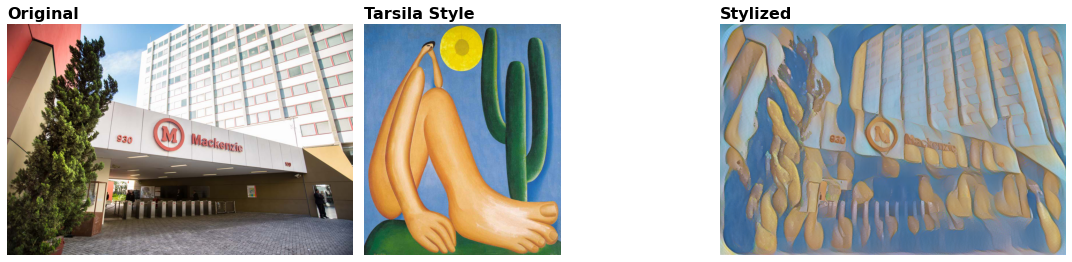

In [29]:
content_image = plt.imread('/content/mackenzie_3740_041017.jpg')
style_image = plt.imread('/content/Tarsila.jpg')

# resize
style_image = image_resize(style_image, height=content_image.shape[0])

# stylized
stylized_image = generate_stylized(content_image,style_image) 
  
# plot
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].imshow(content_image)
ax[0].set_title('Original', fontsize=16, loc='left', weight='bold')
ax[0].set_axis_off()

ax[1].imshow(style_image)
ax[1].set_title('Tarsila Style', fontsize=16, loc='left', weight='bold')
ax[1].set_xlim([0,content_image.shape[1]])
ax[1].set_axis_off()

ax[2].imshow(stylized_image)
ax[2].set_title('Stylized', fontsize=16, loc='left', weight='bold')
ax[2].set_axis_off()

plt.tight_layout()
plt.show()


## Salvando as Imagens

Você pode empregar:

In [27]:
fig.savefig('all_figs.jpg',bbox_inches='tight')

para salvar as imagens de forma conjunta. Ou,

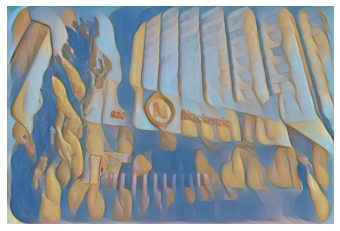

In [25]:
fig, ax = plt.subplots()
ax.imshow(stylized_image)
ax.set_axis_off()

plt.savefig('stylized.jpg',bbox_inches='tight')

para salvar a imagem estilizada de forma isolada.

## Download 

Para fazer o download da imagem desejada você pode empregar:

In [12]:
from google.colab import files

files.download('stylized.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Crie você agora a sua arte... 

## Upload images

Você pode empregar o código abaixo para fazer o upload das suas imagens aqui (ou se quiser buscar uma imagem da internet empregue o comando `!wget` como fizemos acima).

In [13]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Empregue o código que empregamos para criação das imagens estilizadas no exemplo.

In [14]:
# Your code